# SatScan Clustering Classification Model

The purpose of this notebook is to create a classification model to predict whether or not a city belongs to a  high risk cluster.

Cities that belong to a high risk cluster are labeled 1, and cities that do not belong to a high risk cluster are labeled 0.

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located.

---

Importing libraries

In [1]:
import pandas as pd
import numpy as np

# DataPrep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pickle
import joblib

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoplot
import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../../"

C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

all_models_scores = {}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [ ]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [ ]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-1):
    year_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_20" + years[i+1] + ".csv", index_col=0)
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

Filling NaN values with zero and getting state code from MUNCOD column

In [ ]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)
df.head()

Saving dataframe to csv

In [ ]:
df.to_csv("df_classification_satscan.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [ ]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    year_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_20" + years[i+1] + ".csv", index_col=0)
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N)
    train_df = pd.concat([train_df, year_df])

train_df.head()

In [ ]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)
train_df.head()

In [ ]:
train_df.to_csv("train_data_classification_satscan.csv")

Getting testing data (2018)

In [ ]:
percentage_valid_values = 0.8
test_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_2018.csv", index_col=0)
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df[disease] = disease_df[col_year_disease] 
    disease_df = disease_df.drop(columns={col_year_disease})
    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(test_df.shape[1]*percentage_valid_values)
test_df = test_df.dropna(thresh=N)
test_df.head()

In [ ]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['UF'], axis=1)
test_df.head()

In [ ]:
test_df.to_csv("test_data_classification_satscan.csv")

# Model
----

Loading dataframe

In [3]:
df = pd.read_csv("df_classification_satscan.csv",index_col=0)
train_df = pd.read_csv("train_data_classification_satscan.csv", index_col=0)
test_df = pd.read_csv("test_data_classification_satscan.csv", index_col=0)

In [4]:
X_train = train_df.drop(columns=["RISK"])
mm = MinMaxScaler()
mm_x_2018 = mm.fit(X_train)
joblib.dump(mm_x_2018, root + "Dashboard/Models/sav/mm_x_satscan.save")

['../../../Dashboard/Models/sav/mm_x_satscan.save']

Checking the number of 0s and 1s in TARGET column

In [5]:
unique, counts = np.unique(df["RISK"].values, return_counts=True)
dict(zip(unique, counts))

{0: 6032, 1: 3318}

Defining X and y

In [6]:
X = df.drop(columns=["RISK"])
y = df["RISK"]

X.shape

(9350, 340)

Defining some functions

In [7]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature", how="right")
    final_feat_df = final_feat_df.fillna(0)
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df.sort_values(by="Avg_importance", ascending=False)

In [8]:
def sfm_feature_selector(X_train,y_train):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    embeded_rf_selector.fit(X_train, y_train)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features (SFM)')
    return embeded_rf_feature

In [9]:
def get_average(scores_list):
    scores_avg_test = []
    for i in range(len(scores_list[0])):
        arr_list = [x[i] for x in scores_list]
        avg_result = np.array(arr_list).mean(axis=0)
        scores_avg_test.append(avg_result)
    return scores_avg_test

In [10]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None):
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3, zero_division=0))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3, zero_division=0))
    if scores is not None:
        scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                      "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                      "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train, zero_division=0),
                      "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred, zero_division=0)}, ignore_index=True)
        return scores

In [11]:
def get_average_metrics(score):
    print("## Train")
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_score_train = get_average(scores["scores_train"])
    print("accuracy_train:", avg_accuracy_train)
    print("precision_train:", avg_score_train[0].mean())
    print("recall_train:", avg_score_train[1].mean())
    print("f1_score_train:", avg_score_train[2].mean())
    print("## Test")
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_score_test = get_average(scores["scores_test"])
    print("accuracy_test:", avg_accuracy_test)
    print("precision_test:", avg_score_test[0].mean())
    print("recall_test:", avg_score_test[1].mean())
    print("f1_score_test:", avg_score_test[2].mean())

## Naive Bayes

In [12]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_nb  = X_train.drop(columns=list(dict_uf_cod.values()))
    X_test_nb  = X_test.drop(columns=list(dict_uf_cod.values()))
    classifier  = GaussianNB()
    classifier.fit(X_train_nb,y_train);
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test_nb) 
    y_pred_train = classifier.predict(X_train_nb)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY NAIVE BAYES ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Naive Bayes"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Making predictions
# Calculating metrics
Train
[[3717 1109]
 [ 754 1900]]
              precision    recall  f1-score   support

           0      0.831     0.770     0.800      4826
           1      0.631     0.716     0.671      2654

    accuracy                          0.751      7480
   macro avg      0.731     0.743     0.735      7480
weighted avg      0.760     0.751     0.754      7480

Test
[[928 278]
 [220 444]]
              precision    recall  f1-score   support

           0      0.808     0.769     0.788      1206
           1      0.615     0.669     0.641       664

    accuracy                          0.734      1870
   macro avg      0.712     0.719     0.715      1870
weighted avg      0.740     0.734     0.736      1870



=============== RUN 2 ===============
# Making predictions
# Calculating metrics
Train
[[3786 1040]
 [ 811 1843]]
              precision    recall  f1-score   support

           0      0.824     0.785

In [13]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]
X_train_nb  = X_train.drop(columns=list(dict_uf_cod.values()))
classifier  = GaussianNB()
classifier.fit(X_train_nb,y_train);

filename = root + 'Dashboard/Models/sav/naive_bayes_satscan.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Logistic Regression

In [18]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1

feature_importance_coef_list = []
feature_importance_shap_list = []

for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm_x = MinMaxScaler().fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)

    print("# Fitting the model")
    classifier = LogisticRegression(random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    feature_importance_coef_list.append(pd.DataFrame({"Feature": X.columns, "Importance": classifier.coef_[0]}).sort_values(by="Importance", ascending=False))

    explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
  
    print("\n")
    count += 1
print("=============== SUMMARY LOGISTIC REGRESSION ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Logistic Regression"] = scores

final_feat_df_coef = get_average_feat_importance(feature_importance_coef_list)
final_feat_df_coef.to_csv("fi_coef_logistic_regression_satscan.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_logistic_regression_satscan.csv")

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4410  416]
 [ 728 1926]]
              precision    recall  f1-score   support

           0      0.858     0.914     0.885      4826
           1      0.822     0.726     0.771      2654

    accuracy                          0.847      7480
   macro avg      0.840     0.820     0.828      7480
weighted avg      0.846     0.847     0.845      7480

Test
[[1081  125]
 [ 217  447]]
              precision    recall  f1-score   support

           0      0.833     0.896     0.863      1206
           1      0.781     0.673     0.723       664

    accuracy                          0.817      1870
   macro avg      0.807     0.785     0.793      1870
weighted avg      0.815     0.817     0.814      1870

# Get Feature Importance


=============== RUN 2 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4389  437]
 [ 725 1929]]
              precision    recall  f1-score   support

           0      0.858     0.909     0.883      4826
           1      0.815     0.727     0.769      2654

    accuracy                          0.845      7480
   macro avg      0.837     0.818     0.826      7480
weighted avg      0.843     0.845     0.842      7480

Test
[[1079  127]
 [ 188  476]]
              precision    recall  f1-score   support

           0      0.852     0.895     0.873      1206
           1      0.789     0.717     0.751       664

    accuracy                          0.832      1870
   macro avg      0.821     0.806     0.812      1870
weighted avg      0.830     0.832     0.830      1870

# Get Feature Importance


=============== RUN 3 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4377  449]
 [ 702 1952]]
              precision    recall  f1-score   support

           0      0.862     0.907     0.884      4826
           1      0.813     0.735     0.772      2654

    accuracy                          0.846      7480
   macro avg      0.837     0.821     0.828      7480
weighted avg      0.844     0.846     0.844      7480

Test
[[1062  144]
 [ 192  472]]
              precision    recall  f1-score   support

           0      0.847     0.881     0.863      1206
           1      0.766     0.711     0.737       664

    accuracy                          0.820      1870
   macro avg      0.807     0.796     0.800      1870
weighted avg      0.818     0.820     0.819      1870

# Get Feature Importance


=============== RUN 4 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4394  431]
 [ 730 1925]]
              precision    recall  f1-score   support

           0      0.858     0.911     0.883      4825
           1      0.817     0.725     0.768      2655

    accuracy                          0.845      7480
   macro avg      0.837     0.818     0.826      7480
weighted avg      0.843     0.845     0.842      7480

Test
[[1080  127]
 [ 202  461]]
              precision    recall  f1-score   support

           0      0.842     0.895     0.868      1207
           1      0.784     0.695     0.737       663

    accuracy                          0.824      1870
   macro avg      0.813     0.795     0.802      1870
weighted avg      0.822     0.824     0.821      1870

# Get Feature Importance


=============== RUN 5 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4375  450]
 [ 736 1919]]
              precision    recall  f1-score   support

           0      0.856     0.907     0.881      4825
           1      0.810     0.723     0.764      2655

    accuracy                          0.841      7480
   macro avg      0.833     0.815     0.822      7480
weighted avg      0.840     0.841     0.839      7480

Test
[[1093  114]
 [ 210  453]]
              precision    recall  f1-score   support

           0      0.839     0.906     0.871      1207
           1      0.799     0.683     0.737       663

    accuracy                          0.827      1870
   macro avg      0.819     0.794     0.804      1870
weighted avg      0.825     0.827     0.823      1870

# Get Feature Importance


=============== SUMMARY LOGISTIC REGRESSION ===============
# Average Metrics
## Train
accuracy_train: 0.8448128342245989
precision_train: 0.8369634753431017
recall_train: 0.8183473042445406
f1_score_train: 0.82

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# SHAP analysis


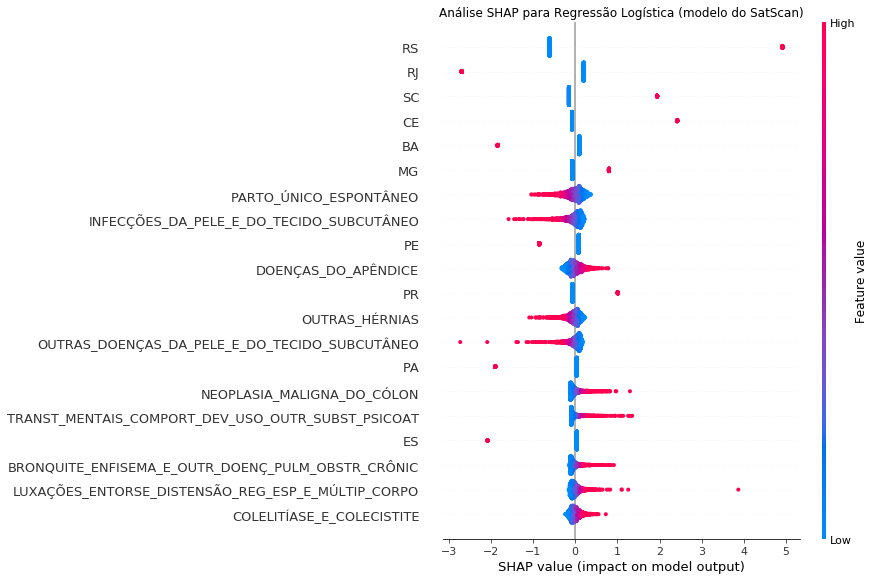

In [21]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("Análise SHAP para Regressão Logística (modelo do SatScan)")
plt.savefig("logistic_regression_shap_satscan.png", bbox_inches = "tight")

In [17]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

X_train = mm_x_2018.transform(X_train)

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

filename = root + 'Dashboard/Models/sav/logistic_regression_satscan_mm.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Random Forest

In [22]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
feature_importance_shap_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: SFM")
    selected_sfm_features = sfm_feature_selector(X_train,y_train)
    X_train = X_train[selected_sfm_features]
    X_test = X_test[selected_sfm_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    n_estimators = resultado_gp.x[0]
    max_depth = resultado_gp.x[1]
    min_samples_leaf = resultado_gp.x[2]
    max_features = resultado_gp.x[3]
    
    print("# Fitting the model")
    classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    classifier.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = classifier.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test)
    
    vals= np.abs(shap_values[1]).mean(0) # se nao funcionar, tirar o [1]
    feature_importance_shap = pd.DataFrame(list(zip(X_test.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
    
    print("\n")
    count += 1
print("=============== SUMMARY RANDOM FOREST ===============")
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
final_feat_df.to_csv("fi_random_forest_satscan.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_random_forest_satscan.csv")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Random Forest"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: SFM
110 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4462  364]
 [1275 1379]]
              precision    recall  f1-score   support

           0      0.778     0.925     0.845      4826
           1      0.791     0.520     0.627      2654

    accuracy                          0.781      7480
   macro avg      0.784     0.722     0.736      7480
weighted avg      0.783     0.781     0.768      7480

Test
[[1113   93]
 [ 325  339]]
              precision    recall  f1-score   support

           0      0.774     0.923     0.842      1206
           1      0.785     0.511     0.619       664

    accuracy                          0.776      1870
   macro avg      0.779     0.717     0.730      1870
weighted avg      0.778     0.776     0.763      1870

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: SFM
118 selected 

The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4306  520]
 [1227 1427]]
              precision    recall  f1-score   support

           0      0.778     0.892     0.831      4826
           1      0.733     0.538     0.620      2654

    accuracy                          0.766      7480
   macro avg      0.756     0.715     0.726      7480
weighted avg      0.762     0.766     0.756      7480

Test
[[1064  142]
 [ 302  362]]
              precision    recall  f1-score   support

           0      0.779     0.882     0.827      1206
           1      0.718     0.545     0.620       664

    accuracy                          0.763      1870
   macro avg      0.749     0.714     0.724      1870
weighted avg      0.757     0.763     0.754      1870

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: SFM
114 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4301  524]
 [1162 1493]]
              precision    recall  f1-score   support

           0      0.787     0.891     0.836      4825
           1      0.740     0.562     0.639      2655

    accuracy                          0.775      7480
   macro avg      0.764     0.727     0.738      7480
weighted avg      0.771     0.775     0.766      7480

Test
[[1073  134]
 [ 288  375]]
              precision    recall  f1-score   support

           0      0.788     0.889     0.836      1207
           1      0.737     0.566     0.640       663

    accuracy                          0.774      1870
   macro avg      0.763     0.727     0.738      1870
weighted avg      0.770     0.774     0.766      1870

# Get Feature Importance


=============== RUN 5 ===============
# Feature Selection: SFM
117 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4534  291]
 [1455 1200]]
              precision    recall  f1-score   support

           0      0.757     0.940     0.839      4825
           1      0.805     0.452     0.579      2655

    accuracy                          0.767      7480
   macro avg      0.781     0.696     0.709      7480
weighted avg      0.774     0.767     0.746      7480

Test
[[1127   80]
 [ 379  284]]
              precision    recall  f1-score   support

           0      0.748     0.934     0.831      1207
           1      0.780     0.428     0.553       663

    accuracy                          0.755      1870
   macro avg      0.764     0.681     0.692      1870
weighted avg      0.760     0.755     0.732      1870

# Get Feature Importance


=============== SUMMARY RANDOM FOREST ===============
# Average Feature Importance
# Average Metrics
## Train
accuracy_train: 0.7713101604278074
precision_train: 0.7695823588133964
recall_tra

# SHAP analysis


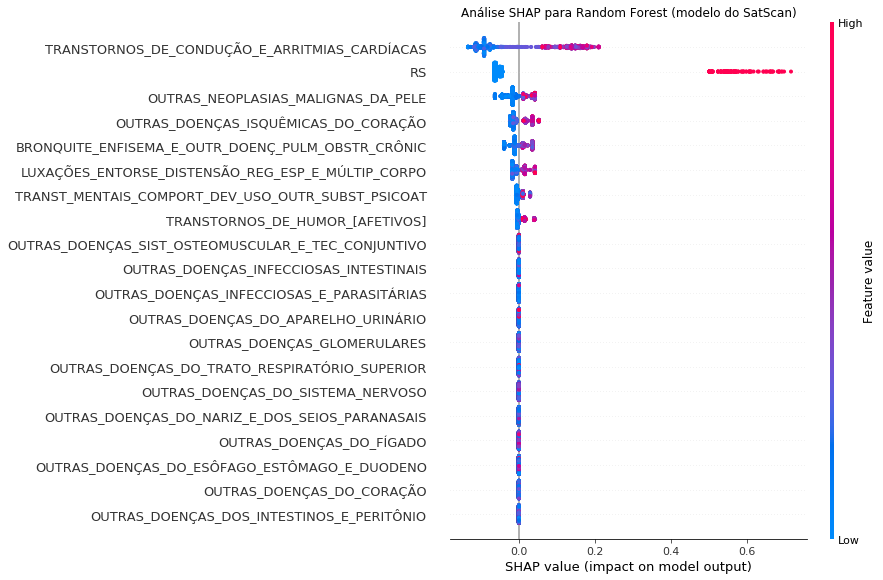

In [23]:
print("# SHAP analysis")
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, show=False)
plt.title("Análise SHAP para Random Forest (modelo do SatScan)")
plt.savefig("random_forest_shap_satscan.png", bbox_inches = "tight")

In [24]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]
print("## Chosen parameters")
print("n_estimators:", n_estimators)
print("max_depth:", max_depth)
print("min_samples_leaf:", min_samples_leaf)
print("max_features:", max_features)

classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/random_forest_satscan.sav'
pickle.dump(classifier, open(filename, 'wb'))

The objective has been evaluated at this point before.


## Chosen parameters
n_estimators: 5
max_depth: 3
min_samples_leaf: 200
max_features: 1.0


### SHAP Individual Analysis

In [25]:
print(test_df.loc[test_df['MUNCOD'] == 355030]["RISK"])

data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "RISK"])
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(data_for_prediction)

3624    0
Name: RISK, dtype: int64


In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

## SVM
### LinearSVC

In [31]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_coef_list = []
feature_importance_shap_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm_x = MinMaxScaler().fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Fitting the model")
    classifier = LinearSVC(random_state=42,dual=False)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    feature_importance_coef = pd.DataFrame({"Feature": X.columns, "Importance": classifier.coef_.ravel()})
    feature_importance_coef.sort_values(by="Importance", ascending=False)
    feature_importance_coef_list.append(feature_importance_coef)

    explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
  
    print("\n")
    count += 1
print("=============== SUMMARY SVM LINEAR ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["LinearSVC"] = scores

final_feat_df_coef = get_average_feat_importance(feature_importance_coef_list)
final_feat_df_coef.to_csv("fi_coef_linear_svc_satscan.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_linear_svc_satscan.csv")

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4406  420]
 [ 677 1977]]
              precision    recall  f1-score   support

           0      0.867     0.913     0.889      4826
           1      0.825     0.745     0.783      2654

    accuracy                          0.853      7480
   macro avg      0.846     0.829     0.836      7480
weighted avg      0.852     0.853     0.852      7480

Test
[[1073  133]
 [ 199  465]]
              precision    recall  f1-score   support

           0      0.844     0.890     0.866      1206
           1      0.778     0.700     0.737       664

    accuracy                          0.822      1870
   macro avg      0.811     0.795     0.801      1870
weighted avg      0.820     0.822     0.820      1870

# Get Feature Importance


=============== RUN 2 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4397  429]
 [ 680 1974]]
              precision    recall  f1-score   support

           0      0.866     0.911     0.888      4826
           1      0.821     0.744     0.781      2654

    accuracy                          0.852      7480
   macro avg      0.844     0.827     0.834      7480
weighted avg      0.850     0.852     0.850      7480

Test
[[1073  133]
 [ 172  492]]
              precision    recall  f1-score   support

           0      0.862     0.890     0.876      1206
           1      0.787     0.741     0.763       664

    accuracy                          0.837      1870
   macro avg      0.825     0.815     0.819      1870
weighted avg      0.835     0.837     0.836      1870

# Get Feature Importance


=============== RUN 3 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4403  423]
 [ 663 1991]]
              precision    recall  f1-score   support

           0      0.869     0.912     0.890      4826
           1      0.825     0.750     0.786      2654

    accuracy                          0.855      7480
   macro avg      0.847     0.831     0.838      7480
weighted avg      0.853     0.855     0.853      7480

Test
[[1051  155]
 [ 185  479]]
              precision    recall  f1-score   support

           0      0.850     0.871     0.861      1206
           1      0.756     0.721     0.738       664

    accuracy                          0.818      1870
   macro avg      0.803     0.796     0.799      1870
weighted avg      0.817     0.818     0.817      1870

# Get Feature Importance


=============== RUN 4 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4404  421]
 [ 679 1976]]
              precision    recall  f1-score   support

           0      0.866     0.913     0.889      4825
           1      0.824     0.744     0.782      2655

    accuracy                          0.853      7480
   macro avg      0.845     0.829     0.836      7480
weighted avg      0.851     0.853     0.851      7480

Test
[[1085  122]
 [ 208  455]]
              precision    recall  f1-score   support

           0      0.839     0.899     0.868      1207
           1      0.789     0.686     0.734       663

    accuracy                          0.824      1870
   macro avg      0.814     0.793     0.801      1870
weighted avg      0.821     0.824     0.820      1870

# Get Feature Importance


=============== RUN 5 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[4393  432]
 [ 675 1980]]
              precision    recall  f1-score   support

           0      0.867     0.910     0.888      4825
           1      0.821     0.746     0.782      2655

    accuracy                          0.852      7480
   macro avg      0.844     0.828     0.835      7480
weighted avg      0.851     0.852     0.850      7480

Test
[[1082  125]
 [ 209  454]]
              precision    recall  f1-score   support

           0      0.838     0.896     0.866      1207
           1      0.784     0.685     0.731       663

    accuracy                          0.821      1870
   macro avg      0.811     0.791     0.799      1870
weighted avg      0.819     0.821     0.818      1870

# Get Feature Importance


=============== SUMMARY SVM LINEAR ===============
# Average Metrics
## Train
accuracy_train: 0.8529679144385028
precision_train: 0.8451515533658158
recall_train: 0.8288543653342655
f1_score_train: 0.83576234825

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# SHAP analysis


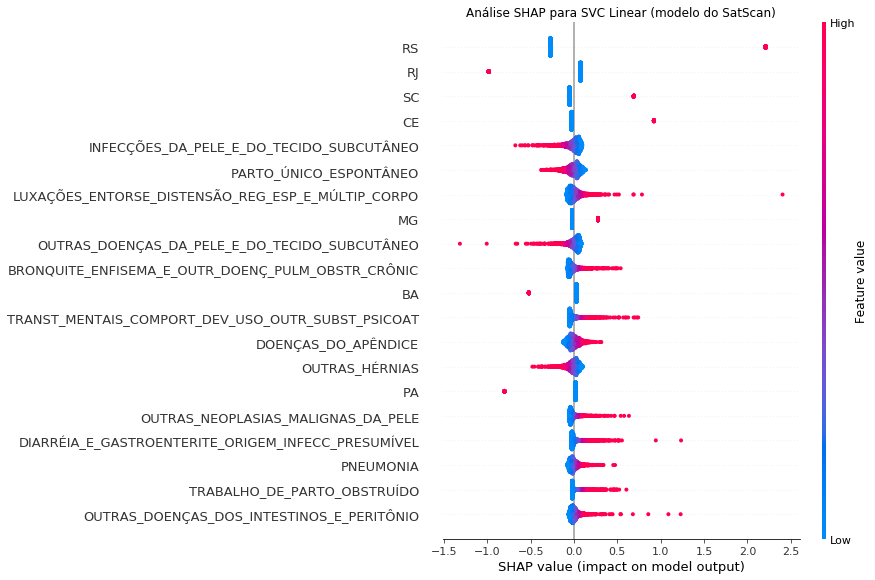

In [33]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("Análise SHAP para SVC Linear (modelo do SatScan)")
plt.savefig("svc_linear_shap_satscan.png", bbox_inches = "tight")

In [34]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

X_train = mm_x_2018.transform(X_train)

classifier = LinearSVC(random_state=42, dual=False)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_linear_satscan.sav'
pickle.dump(classifier, open(filename, 'wb'))

### SVC (RBF Kernel)

In [35]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm_x = MinMaxScaler().fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)

    print("\n")
    count += 1
print("=============== SUMMARY SVM RBF ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM RBF"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4515  311]
 [ 723 1931]]
              precision    recall  f1-score   support

           0      0.862     0.936     0.897      4826
           1      0.861     0.728     0.789      2654

    accuracy                          0.862      7480
   macro avg      0.862     0.832     0.843      7480
weighted avg      0.862     0.862     0.859      7480

Test
[[1098  108]
 [ 235  429]]
              precision    recall  f1-score   support

           0      0.824     0.910     0.865      1206
           1      0.799     0.646     0.714       664

    accuracy                          0.817      1870
   macro avg      0.811     0.778     0.790      1870
weighted avg      0.815     0.817     0.811      1870



=============== RUN 2 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating

In [36]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = mm_x.transform(X_train)
X_test = mm_x.transform(X_test)

def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]
print("## Chosen parameters")
print("C:", C)

classifier = SVC(random_state=42,C=C)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_rbf_satscan.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Chosen parameters
C: 0.28995234005420556


# All Models
----

Getting a summary of all training results

In [37]:
df_result_train = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_train = get_average(scores["scores_train"])
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_precision_train = avg_score_train[0].mean()
    avg_recall_train = avg_score_train[1].mean()
    avg_f1_score_train = avg_score_train[2].mean()
    df_result_train = df_result_train.append({"Model": model, 
                                  "Accuracy": avg_accuracy_train, "Precision": avg_precision_train,
                                  "Recall": avg_recall_train, "F1-Score": avg_f1_score_train},ignore_index=True)
df_result_train

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.751765,0.731170,0.740351,0.734597
1,Logistic Regression,0.844813,0.836963,0.818347,0.826011
2,Random Forest,0.771310,0.769582,0.714140,0.726250
3,LinearSVC,0.852968,0.845152,0.828854,0.835762
4,SVM RBF,0.860374,0.857686,0.832357,0.842351


Getting a summary of all testing results

In [38]:
df_result_test = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_test = get_average(scores["scores_test"])
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_precision_test = avg_score_test[0].mean()
    avg_recall_test = avg_score_test[1].mean()
    avg_f1_score_test = avg_score_test[2].mean()
    df_result_test = df_result_test.append({"Model": model, 
                                  "Accuracy": avg_accuracy_test, "Precision": avg_precision_test,
                                  "Recall": avg_recall_test, "F1-Score": avg_f1_score_test},ignore_index=True)
df_result_test

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.742995,0.722198,0.730968,0.725147
1,Logistic Regression,0.823957,0.813264,0.795146,0.802397
2,Random Forest,0.766203,0.762273,0.708888,0.720175
3,LinearSVC,0.824492,0.812595,0.797996,0.803996
4,SVM RBF,0.833904,0.827928,0.801840,0.811636


# Predictions 2018

Defining X and y

In [35]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]
X_test = test_df.drop(columns=["RISK", "MUNCOD"])
y_test = test_df["RISK"]

mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

print("# Bayesian Optimization")
def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("# Fitting the model")
classifier = SVC(random_state=42,C=C,probability=True)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None)

# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[5167  318]
 [ 809 2121]]
              precision    recall  f1-score   support

           0      0.865     0.942     0.902      5485
           1      0.870     0.724     0.790      2930

    accuracy                          0.866      8415
   macro avg      0.867     0.833     0.846      8415
weighted avg      0.866     0.866     0.863      8415

Test
[[520  27]
 [189 199]]
              precision    recall  f1-score   support

           0      0.733     0.951     0.828       547
           1      0.881     0.513     0.648       388

    accuracy                          0.769       935
   macro avg      0.807     0.732     0.738       935
weighted avg      0.794     0.769     0.753       935



In [36]:
gd = gpd.read_file(root + "Maps/BRMUE250GC_SIR.shp")

mun_risk_ids_pred = test_df[y_pred == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true = test_df[y_test == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_1_correct = [x for x in mun_risk_ids_pred if x in mun_risk_ids_true]

mun_risk_ids_pred_0 = test_df[y_pred == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true_0 = test_df[y_test == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_0_correct = [x for x in mun_risk_ids_pred_0 if x in mun_risk_ids_true_0]

mun_risk_ids = mun_risk_ids_1_correct + mun_risk_ids_0_correct
mun_risk_ids_wrong = [x for x in mun_risk_ids_pred if x not in mun_risk_ids_true] + [x for x in mun_risk_ids_true if x not in mun_risk_ids_pred]

In [37]:
def remove_last_digit(x):
    return np.floor(x.astype(int) / 10).astype(int)

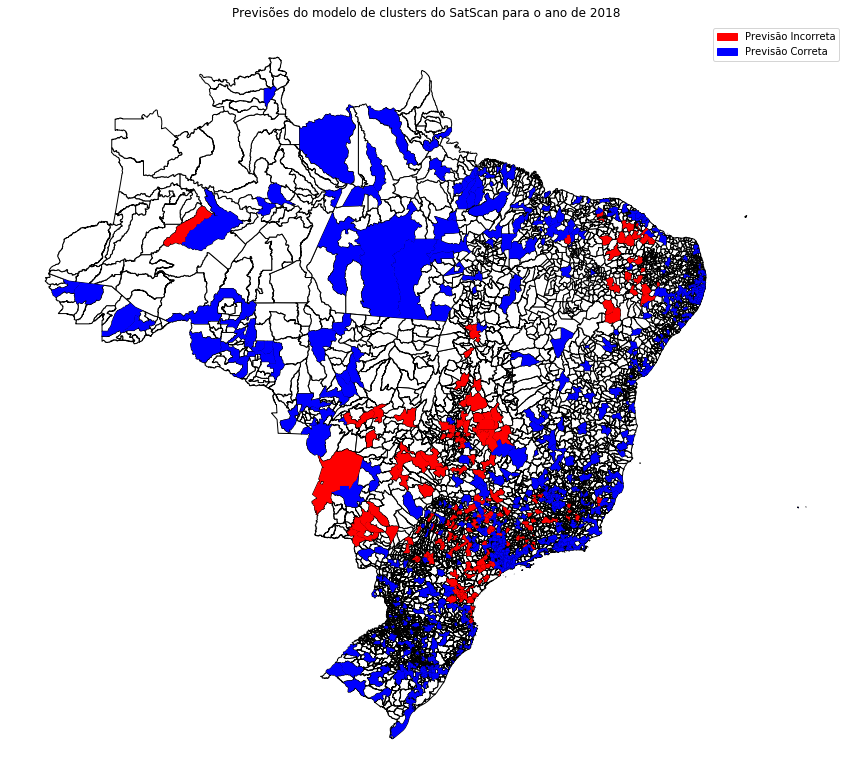

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
gd.plot(ax=ax, color="white", edgecolor='black')
gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
plot_risk = gd_risk.plot(ax=ax, color="blue")

gd_risk_wrong = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_wrong)]
plot_risk_wrong = gd_risk_wrong.plot(ax=ax, color="red")

blue_patch = mpatches.Patch(color='blue', label='Previsão Correta')
red_patch = mpatches.Patch(color='red', label='Previsão Incorreta')
plt.title("Previsões do modelo de clusters do SatScan para o ano de 2018")
plt.legend(handles=[red_patch,blue_patch])
plt.axis('off')
plt.savefig("previsoes_clusters_satscan.png")